<a href="https://colab.research.google.com/github/anuragsingh17ai/Computer-Vision/blob/main/01_vehicle_classification_using_TinyVGG_less_Efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Getting Data

In [ ]:
import requests


with open("dataset.zip", "wb") as f:
  request = requests.get("https://github.com/anuragsingh17ai/Computer-Vision/raw/main/datasets/dataset.zip")
  f.write(request.content)

In [ ]:
#Unzip pizza, steak, sushi data
import zipfile
with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
  print("Unzipping data ...")
  zip_ref.extractall()

Unzipping pizza, steak and shushi data ...


In [ ]:
!rm -rf "dataset.zip"

In [ ]:
train_dir =  "vehicle_dataset/train"
test_dir = "vehicle_dataset/val"

## 2. Converting Data into Dataloaders of batch size 32

* Here we are using our own transform that is inspired by tinyVGG
* Image dimension will be cropped in (3,64,64) -> (C,H,W)
* This is done to make every image uniform and reduce processing

In [ ]:
from torchvision.transforms import v2
import torch
from torch import nn

manual_transform = v2.Compose([v2.Resize(size=(64,64)),
                               v2.ToImage(),
                               v2.ToDtype(torch.float, scale=True)
                                ])

In [ ]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=manual_transform)

test_dataset = datasets.ImageFolder(root= test_dir,
                                    transform = manual_transform)

len(train_dataset), len(test_dataset)

(2719, 765)

In [ ]:
class_names = train_dataset.classes
class_names

['auto-rickshaw',
 'bicycle',
 'bus',
 'car',
 'e-rickshaw',
 'mini-bus',
 'mini-truck',
 'motorcycle',
 'rickshaw',
 'tractor',
 'truck',
 'van']

auto-rickshaw


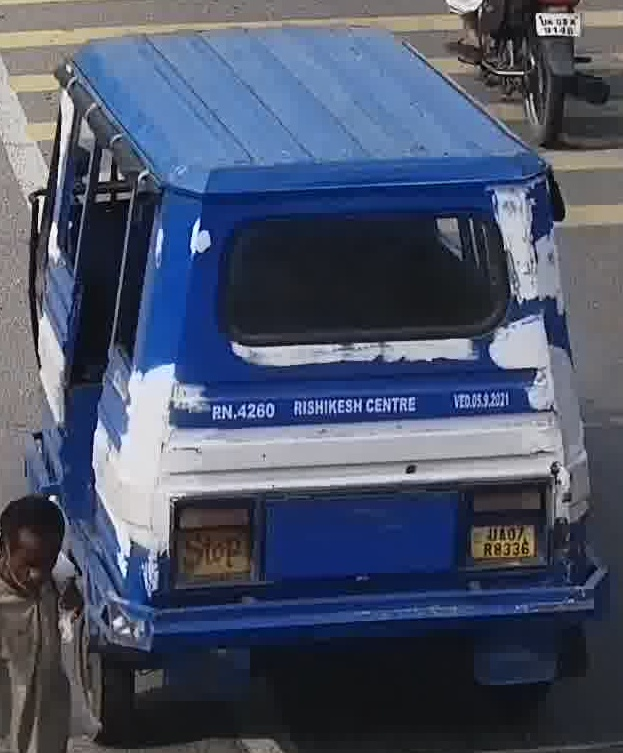

In [ ]:
from PIL import Image

print(class_names[train_dataset.imgs[0][1]])
Image.open(train_dataset.imgs[0][0])

In [ ]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset = train_dataset,
                              shuffle= True,
                              batch_size = BATCH_SIZE,
                              num_workers= NUM_WORKERS ,
                              pin_memory=True)

test_dataloader = DataLoader(dataset= test_dataset,
                             shuffle=False,
                             batch_size = BATCH_SIZE,
                             num_workers= NUM_WORKERS ,
                             pin_memory=True)

len(train_dataloader), len(test_dataloader)

(85, 24)

## 3. Creating model architecture

* Here we will be using tiny VGG just as an experiment if this doesn't worked well we will move on with transfer learning

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self,
              in_channels: int,
              out_channels: int,
              hidden_units: int):

    super().__init__()


    self.layer_1 = nn.Sequential(
        nn.Conv2d(in_channels = in_channels, out_channels= hidden_units, kernel_size = 3, stride=1, padding=0 ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size=3, stride=1, padding=0 ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride=2)
    )
    self.layer_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels= hidden_units, kernel_size = 3, stride = 1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride = 1, padding= 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer_3 =nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*13*13,
                  out_features=out_channels)
    )

  def forward(self,x):
    x = self.layer_1(x)
    # print(x.shape)  # I am doing to find shape of our tensor/logits after every block
    x = self.layer_2(x)
    # print(x.shape)    # this will help me to identify shape of input_feature after flattening of tensor
    x = self.layer_3(x)
    # print(x.shape)
    return x

model_0 = TinyVGG(in_channels=3,out_channels= len(class_names), hidden_units = 10).to(device)
model_0

TinyVGG(
  (layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=12, bias=True)
  )
)

In [ ]:
x = torch.randn(size=(3,64,64)).unsqueeze(dim=0).to(device)
model_0(x)

tensor([[-0.0315,  0.0533, -0.0491,  0.1033,  0.0070, -0.0376,  0.0537,  0.0720,
          0.0481, -0.0845,  0.0858,  0.0571]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## 4. Intiating loss function and optimizer
* Here we will be using CrossEntropy loss that performs well with multiclass classification
* for optimizer we will use Adam optimizer -> this experimental and we can change it

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr = 0.001)  # here 0.01 is default learning rate of Adam optimizer


loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

## 5. Training and Testing Step

In [ ]:
def train_step(model:torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               device:torch.device,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  train_loss, train_acc = 0.0 , 0.0

  model.train()
  for batch, (X,y) in enumerate(train_dataloader):

    X,y = X.to(device), y.to(device) # moving image tensor , and labels on available  device

    y_pred = model_0(X)    # raw logits

    loss = loss_fn(y_pred, y)  # this will implement softmax function internally so no need to externally apply it
    train_loss += loss.item()

    optimizer.zero_grad()        # here we are reducing gradient accumulation to zero
    loss.backward()              # backpropogation
    optimizer.step()             # weights will be updated


    y_class = torch.argmax(torch.softmax(y_pred,dim=1), dim = 1)
    train_acc += (y_class == y).sum().item()/len(y_pred)

  # finding average loss and accuracy
  train_acc = train_acc / len(train_dataloader)
  train_loss = train_loss / len(train_dataloader)
  return train_loss, train_acc


In [ ]:

def test_step(model:torch.nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              device: torch.device,
              loss_fn: torch.nn.Module,
              ):
  test_loss, test_acc = 0.0, 0.0
  model.eval()
  for batch, (X,y) in enumerate(test_dataloader):
    X,y = X.to(device), y.to(device)
    with torch.inference_mode():
      y_pred = model(X)
      y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
      test_loss += loss_fn(y_pred, y).item()
      test_acc += (y_pred_class==y).sum().item()/len(y_pred)

  test_loss= test_loss / len(test_dataloader)
  test_acc = test_acc / len(test_dataloader)

  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm
def train(epochs:int,
          model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer):

  results = {"train_loss":[],
            "train_acc":[],
            "test_loss":[],
            "test_acc":[]}

  for epoch in tqdm(range(epochs)):
    train_loss ,train_acc = train_step(model=model,
                                      train_dataloader=train_dataloader,
                                      device = device,
                                      loss_fn= loss_fn,
                                      optimizer = optimizer)

    test_loss, test_acc = test_step(model= model,
                                    test_dataloader= test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    results["train_acc"].append(train_acc)
    results["train_loss"].append(train_loss)
    results["test_acc"].append(test_acc)
    results["test_loss"].append(test_loss)

  return results



In [ ]:
results = train(epochs = 20,
                model= model_0,
                train_dataloader= train_dataloader,
                test_dataloader = test_dataloader,
                loss_fn = loss_fn,
                optimizer = optimizer)

print(results)

  0%|          | 0/20 [00:00<?, ?it/s]

{'train_loss': [2.229707566429587, 1.7845606761820176, 1.3950629598954145, 1.2355641021448023, 1.0732323898988612, 1.0001411697443794, 0.8959050304749433, 0.8330069882028243, 0.7413058607017293, 0.6756194363622104, 0.6150806402458864, 0.5663860738277435, 0.506585400244769, 0.4582154560615035, 0.4308453957824146, 0.3593991086763494, 0.3495724859483102, 0.2852351643583354, 0.2292040990994257, 0.21042074293774718], 'train_acc': [0.17254506641366224, 0.3910341555977229, 0.5384724857685009, 0.5917101518026565, 0.6392077798861481, 0.6707898481973434, 0.7020635673624288, 0.7219639468690702, 0.7547082542694498, 0.773055028462998, 0.7929316888045541, 0.8054554079696395, 0.8311076850094876, 0.8429672675521822, 0.8569734345351043, 0.8764231499051234, 0.8808467741935484, 0.9084203036053131, 0.9205763757115749, 0.9301114800759014], 'test_loss': [2.074944421648979, 1.4385738397638004, 1.2691583633422852, 1.2158127203583717, 1.2200494234760602, 1.1991650400062401, 1.1108852947751682, 1.08616653829813

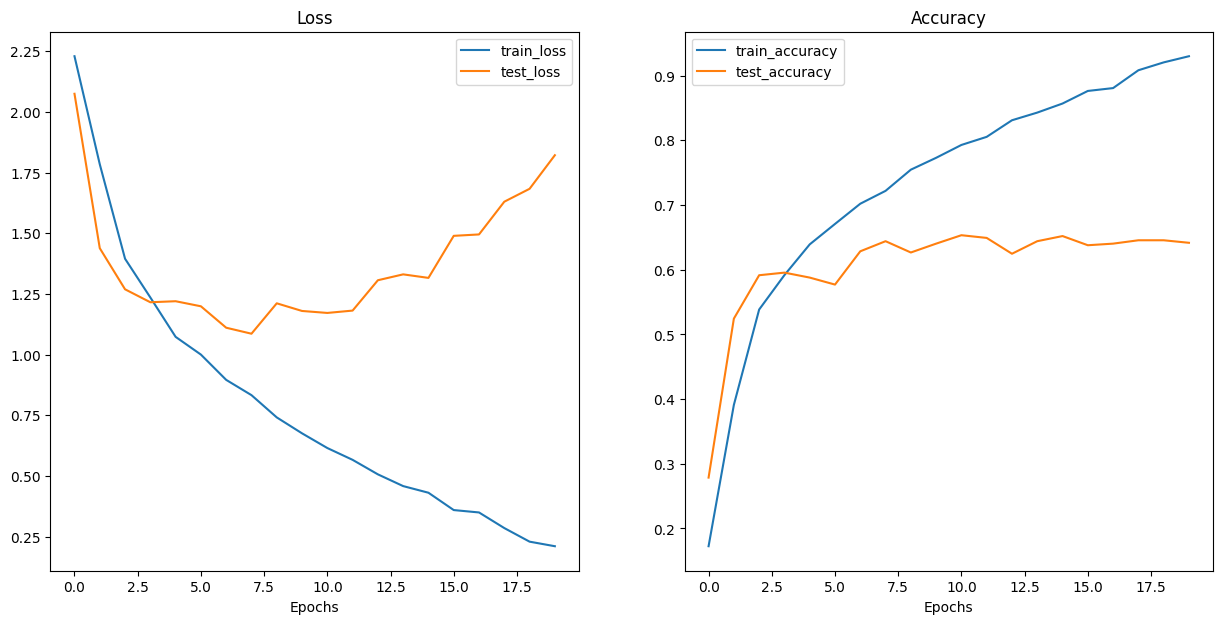

In [ ]:
import matplotlib.pyplot as plt
from typing import Dict, List
def plot_loss_curve(results: Dict[str, List[float]]):
  """ Plot training curve of a results dictionary"""
  # Get the loss values of results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curve(results)

In [ ]:
### Here our model is overfitting